In [1]:
import datetime as datetime
import datetime 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
dataTroca = pd.read_csv('events.csv') 
dataTroca.info()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011288 entries, 0 to 1011287
Data columns (total 23 columns):
timestamp                   1011288 non-null object
event                       1011288 non-null object
person                      1011288 non-null object
url                         82756 non-null object
sku                         563838 non-null object
model                       564284 non-null object
condition                   563836 non-null object
storage                     563836 non-null object
color                       563836 non-null object
skus                        221699 non-null object
search_term                 48967 non-null object
staticpage                  3598 non-null object
campaign_source             82796 non-null object
search_engine               50957 non-null object
channel                     87378 non-null object
new_vs_returning            87378 non-null object
city                        87378 non-null object
region                    

In [2]:
#Convierto la fecha de crecion en un datetime64[ns]
dataTroca['timestamp'] = pd.to_datetime(dataTroca['timestamp'])

In [3]:
groupbyPersonas = dataTroca.loc[:,['person', 'event']].groupby('person')
dicc = {}
for clave, data in groupbyPersonas:
    lista = []
    lista = data.drop_duplicates(subset = 'event', keep = 'first')['event'].tolist()
    dicc[clave] = lista

In [4]:
#Obtengo una lista de todos los eventos que tiene esa persona
dataTroca['eventos'] = dataTroca['person'].map(lambda x: dicc[x])
#Obtengo los dias de la seman
dataTroca['dayweek'] = dataTroca.timestamp.dt.dayofweek
#Obtengo la fecha
dataTroca['fecha'] = dataTroca.timestamp.dt.date
#Separo la marca
dataTroca['marca'] = dataTroca['model'].map(lambda x: str(x).split()[0])

In [5]:
#cantidad de personas que ingresaron 27624.
groupbyCantEventos = dataTroca.groupby('person', as_index = False)['event'].agg({'cantEventos': 'count'})
groupbyCantEventos.sort_values(by = 'cantEventos', ascending = False)
dataTroca = pd.merge(dataTroca, groupbyCantEventos, on = 'person')

In [6]:
#Filtro a la gente que no tiene el evento visited_site 
personasConVisitas = dataTroca.loc[dataTroca['event'] == 'visited site']\
                              .drop_duplicates(subset = 'person', keep = 'first')['person'].tolist()

dataNotVisit = dataTroca.loc[dataTroca['person'].isin(personasConVisitas)]

In [7]:
#pierdo solo 2489 registros
dataTroca['timestamp'].count() - dataNotVisit['timestamp'].count()

2489

In [8]:
dataAux = dataNotVisit.loc[dataNotVisit['event'] == 'visited site'].groupby(['person', 'fecha'], as_index = False).agg({'city': 'first', 'region': 'first', 'country': 'first', 'device_type': 'first', 'operating_system_version': 'first', 'channel': 'first', 'new_vs_returning': 'first'})

In [9]:
events = pd.merge(dataNotVisit, dataAux, on = ['person', 'fecha'])
events.drop(['region_x', 'device_type_x', 'operating_system_version_x', 'country_x', 'city_x', 'channel_x', 'new_vs_returning_x'], axis = 1, inplace = True)
events.rename(columns = {'region_y': 'region', 'device_type_y': 'device_type', 'operating_system_version_y': 'SO', 'city_y': 'city', 'country_y': 'country', 'channel_y': 'channel', 'new_vs_returning_y': 'new_vs_returning'}, inplace =True)

In [10]:
def obtenerSistema(so):
    sistema = so.split()
    if len(sistema) > 1:
        otro = sistema[1].split('.')[0]
        return sistema[0] + ' ' + otro
    else:
        return sistema[0]

In [11]:
weekDays = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']
monthNames = ["", 'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

In [12]:
events['SO'] = events['SO'].map(obtenerSistema)
events['week'] = events.timestamp.dt.week
events['month'] = events.timestamp.dt.month
events['month_name'] = events['month'].map(lambda x: monthNames[x] )
events['weekday'] = events.timestamp.dt.weekday
events['weekday_name'] = events['weekday'].map((lambda x: weekDays[x] ))
events['hour'] = events.timestamp.dt.hour
events['month_day'] = events.timestamp.dt.day

In [13]:
events.info() # Este es el dataFrame a utilizar.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999967 entries, 0 to 999966
Data columns (total 35 columns):
timestamp            999967 non-null datetime64[ns]
event                999967 non-null object
person               999967 non-null object
url                  82004 non-null object
sku                  556407 non-null object
model                556783 non-null object
condition            556405 non-null object
storage              556405 non-null object
color                556405 non-null object
skus                 219093 non-null object
search_term          48256 non-null object
staticpage           3533 non-null object
campaign_source      82040 non-null object
search_engine        50645 non-null object
screen_resolution    87378 non-null object
browser_version      87378 non-null object
eventos              999967 non-null object
dayweek              999967 non-null int64
fecha                999967 non-null object
marca                999967 non-null object
cantEvento

In [14]:
#Obtener las personas con conversiones
dataConversion = events.loc[events['event'] == 'conversion']
personasCompraron = dataConversion.drop_duplicates(subset = 'person', keep = 'first')['person'].tolist()
dataPersonasCompraron = events.loc[events['person'].isin(personasCompraron)]

In [15]:
dataConversionesRegion = dataConversion.groupby('region', as_index = False)['timestamp'].agg({'cantConversionesRegion': 'count'})
dataFiltrada = pd.merge(events, dataConversionesRegion, on = 'region', how= 'left')

In [16]:
dataFiltrada['cantConversionesRegion'] = dataFiltrada['cantConversionesRegion'].fillna(0)

In [17]:
dataFiltrada.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999967 entries, 0 to 999966
Data columns (total 36 columns):
timestamp                 999967 non-null datetime64[ns]
event                     999967 non-null object
person                    999967 non-null object
url                       82004 non-null object
sku                       556407 non-null object
model                     556783 non-null object
condition                 556405 non-null object
storage                   556405 non-null object
color                     556405 non-null object
skus                      219093 non-null object
search_term               48256 non-null object
staticpage                3533 non-null object
campaign_source           82040 non-null object
search_engine             50645 non-null object
screen_resolution         87378 non-null object
browser_version           87378 non-null object
eventos                   999967 non-null object
dayweek                   999967 non-null int64
fecha   

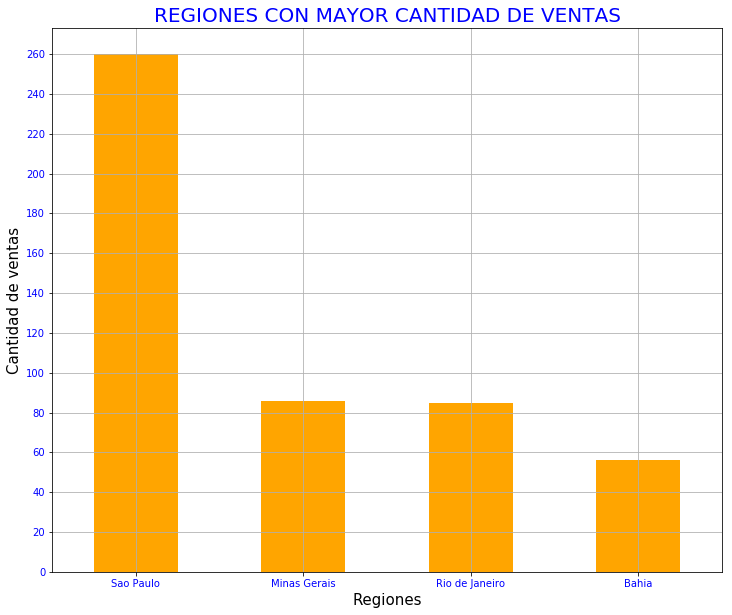

In [77]:
#Veo cuales son las 4 regiones con mas conversiones
#Se corresponden con las regiones con mayor poblacion 
#https://www.efe.com/efe/america/portada/la-poblacion-de-brasil-llega-a-207-7-millones-habitantes-en-2017/20000064-3365437
ventasPorRegion = dataConversion.loc[dataConversion['region'] != 'Unknown'].groupby('region')
ventasPorRegionTop4 = ventasPorRegion['timestamp'].count().sort_values(ascending=False).head(4)

ventasPorRegionTop4.plot(kind = 'bar', figsize= (12, 10), color = 'orange')

plt.ylabel('Cantidad de ventas', fontsize = 15);
plt.xlabel('Regiones', fontsize = 15);
plt.xticks(rotation = 0, color = 'b', fontsize = 10)
plt.yticks(np.arange(0, 270, step=20), color = 'b', fontsize = 10)
plt.grid(True);
plt.title('REGIONES CON MAYOR CANTIDAD DE VENTAS', fontsize = 20, color = 'blue')

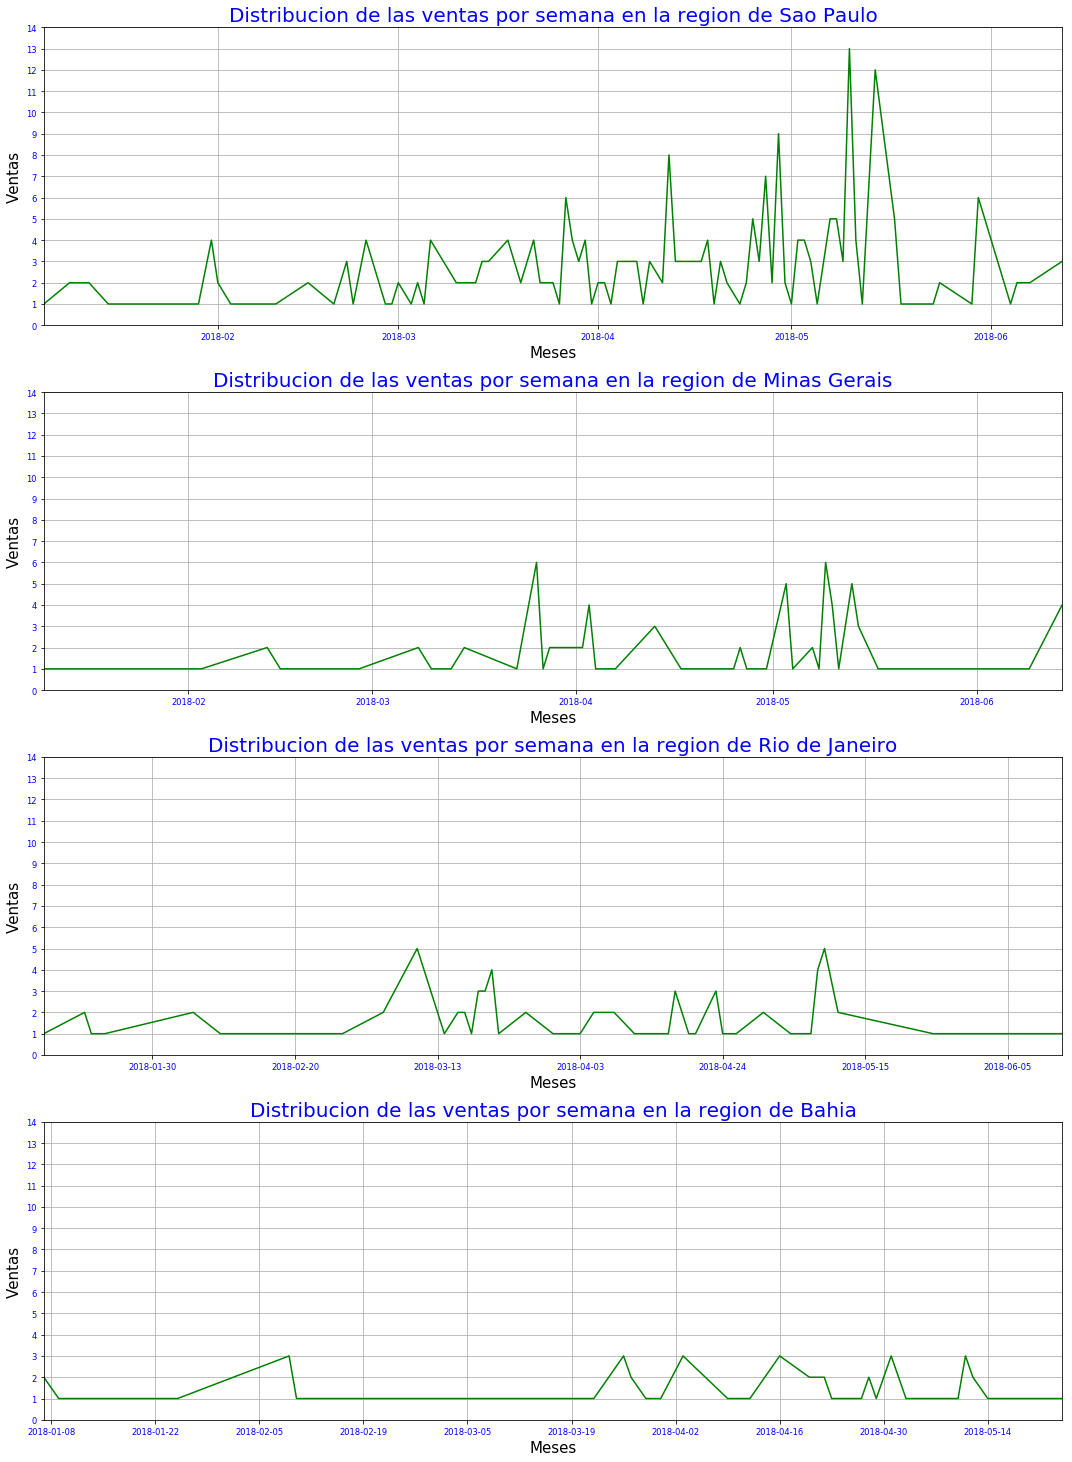

In [85]:
#Veo como se distribuyen las ventas en las regiones, a lo largo de los dias del anio

regiones = [ventasPorRegion.get_group('Sao Paulo'),\
            ventasPorRegion.get_group('Minas Gerais'),\
            ventasPorRegion.get_group('Rio de Janeiro'),\
            ventasPorRegion.get_group('Bahia')]

nombresRegiones = ['Sao Paulo', 'Minas Gerais', 'Rio de Janeiro', 'Bahia']
plt.figure(figsize=(50, 10));


for i in range(len(regiones)):
    regiones[i] = regiones[i].groupby('fecha')['timestamp'].count()
    
    plt.subplot(511 + i );
    ax.set_xlim([0, 200]);

    plt.grid(True);
    regiones[i].plot.line(figsize=(15,25), color ='green', fontsize=15)
    plt.xticks(size = 'small', color = 'b')
    plt.yticks(np.arange(0, 15, step=1), size = 'small', color = 'b')
    plt.grid(True);
    plt.title('Distribucion de las ventas por semana en la region de ' + nombresRegiones[i] , fontsize = 20, color = 'blue')  
    plt.ylabel('Ventas', fontsize = 15);
    plt.xlabel('Meses', fontsize = 15);
plt.tight_layout();


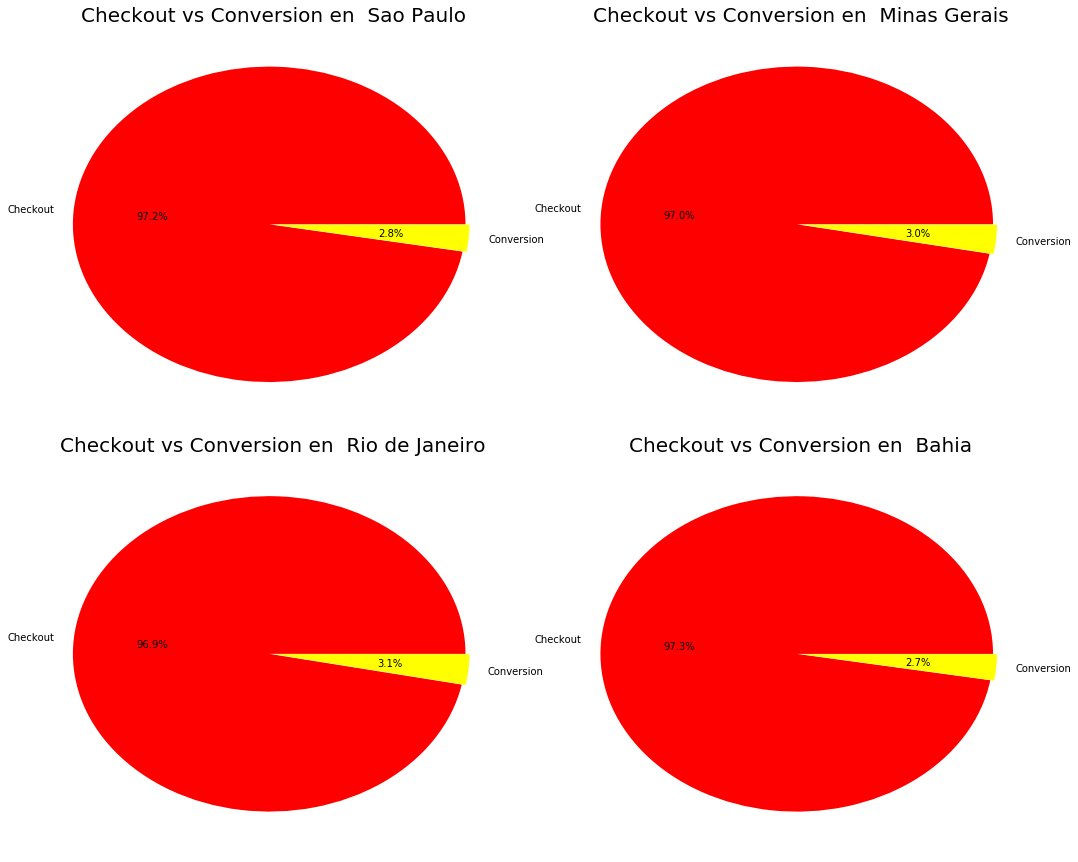

In [30]:
#Aun en las regiones con mas ventas el porcentaje de conversiones es muy pequeno
eventosPorRegion = dataFiltrada.loc[dataFiltrada['region'] != 'Unknown'].groupby('region')
regiones = [eventosPorRegion.get_group('Sao Paulo'),\
            eventosPorRegion.get_group('Minas Gerais'),\
            eventosPorRegion.get_group('Rio de Janeiro'),\
            eventosPorRegion.get_group('Bahia')]

plt.figure(figsize=(15, 18));

for i in range(len(regiones)): 
    tam = []
    tam.append(regiones[i].loc[regiones[i]['event'] == 'checkout']['timestamp'].count())
    tam.append(regiones[i].loc[regiones[i]['event'] == 'conversion']['timestamp'].count()) 
    
    ax = plt.subplot(321 + i );
    plt.pie(tam, labels = ['Checkout','Conversion'], autopct='%1.1f%%', colors=['red', 'yellow'], explode=(0.02, 0))
    plt.title('Checkout vs Conversion en  ' + nombresRegiones[i], fontsize = 20);
plt.tight_layout();


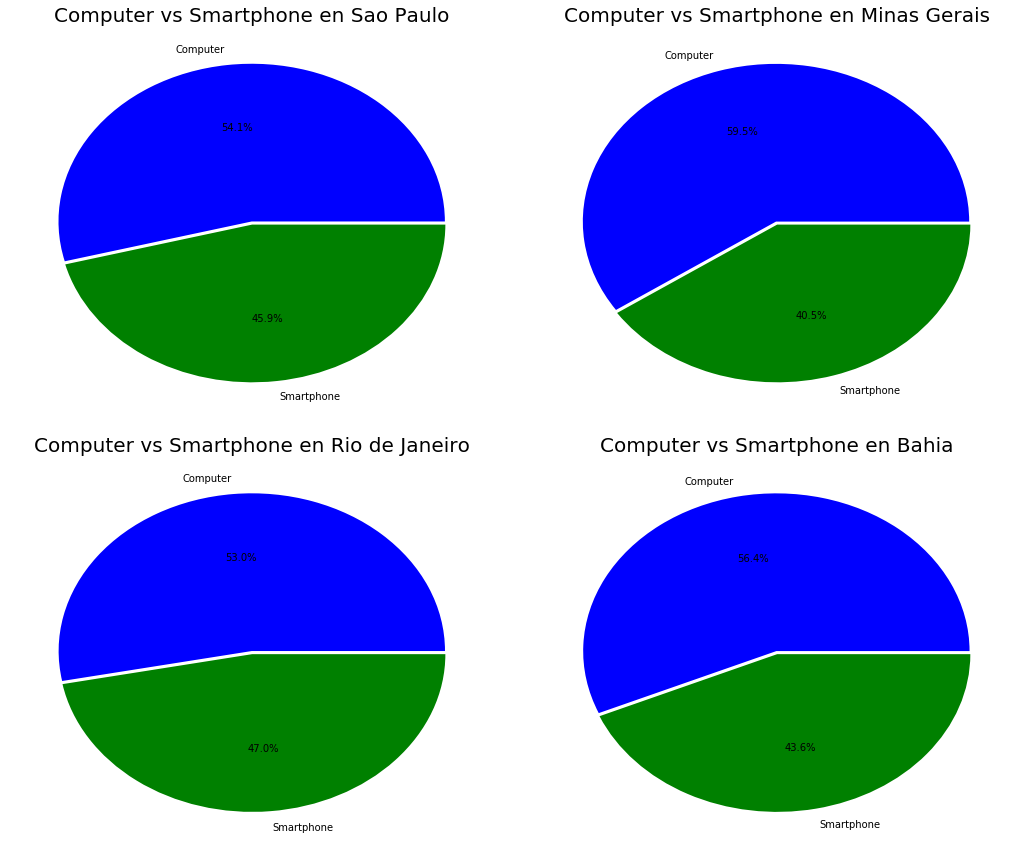

In [38]:
#Ver desde que dispositivo se realizan las ventas en las distintas Regiones
plt.figure(figsize=(15, 18));

for i in range(len(regiones)): 
    tam = []
    tam.append(regiones[i].loc[regiones[i]['device_type'] == 'Computer']['timestamp'].count())
    tam.append(regiones[i].loc[regiones[i]['device_type'] == 'Smartphone']['timestamp'].count()) 
    
    ax = plt.subplot(321 + i );
    plt.pie(tam, labels = ['Computer','Smartphone'], autopct='%1.1f%%', colors=['blue', 'green'], explode=(0.02, 0))
    plt.title('Computer vs Smartphone en ' + nombresRegiones[i], fontsize = 20);
plt.tight_layout();

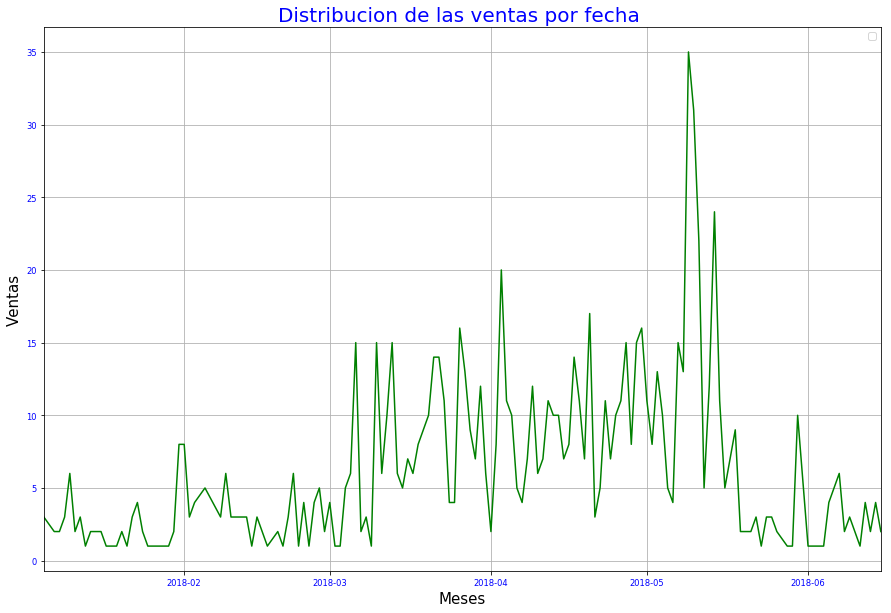

In [42]:
#Distribucion de las ventas a lo largo de los meses
groupbyVentasPorFecha = dataConversion.groupby('fecha')
fechas = np.arange(1, groupbyVentasPorFecha.ngroups + 1, step = 7)

groupbyVentasPorFecha['timestamp'].count().plot.line(figsize=(15,10), color ='green', fontsize=15)
plt.grid(True);
plt.title('Distribucion de las ventas por fecha ' , fontsize = 20, color = 'blue')  
plt.ylabel('Ventas', fontsize = 15)
plt.xlabel('Meses', fontsize = 15)
plt.xticks(size = 'small', color = 'b')
plt.yticks(size = 'small', color = 'b')
plt.legend('')

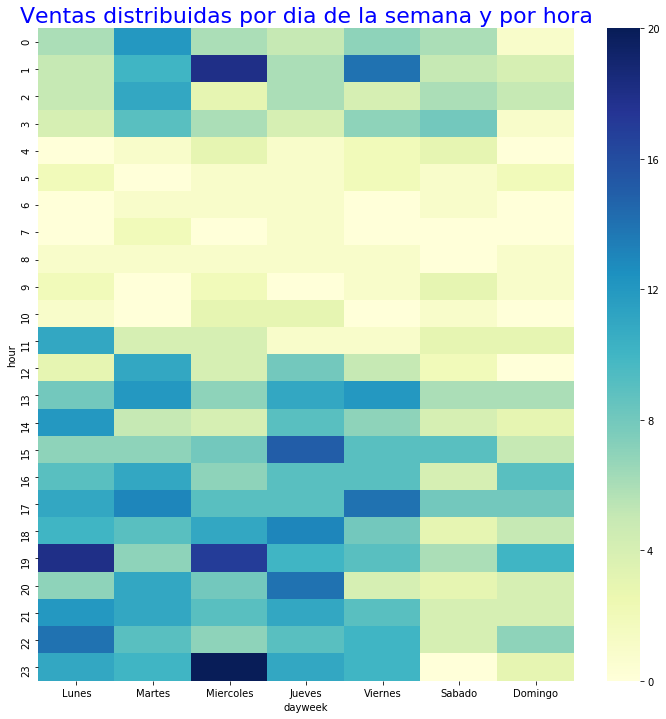

In [56]:
#Conversiones por dia de la semana y hora
df = dataConversion.loc[:, ['hour', 'dayweek']]\
.pivot_table(index='hour', columns='dayweek', aggfunc='size', fill_value=0)


plt.figure(figsize=(12, 12));
plt.title('Ventas distribuidas por dia de la semana y por hora', fontsize = 22, color = 'Blue');
ax = sns.heatmap(df, xticklabels = weekDays ,cmap="YlGnBu" )

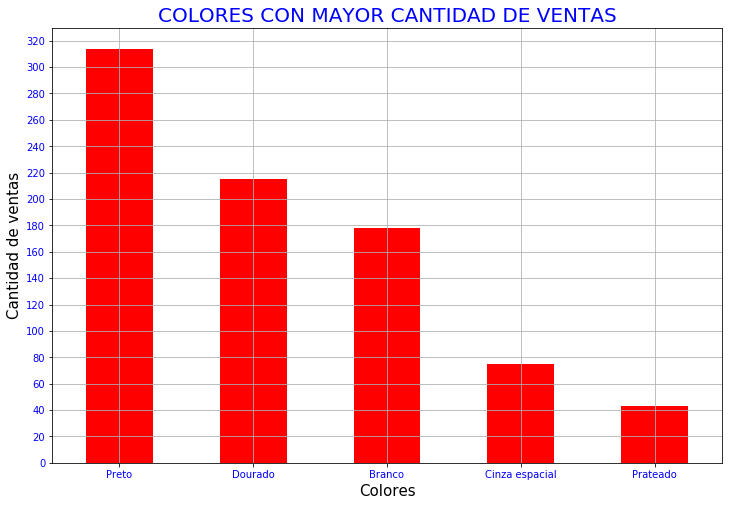

In [73]:
coloresVentasTop5 = dataConversion.groupby('color')['timestamp'].count().sort_values(ascending = False).head()


coloresVentasTop5.plot(kind = 'bar', figsize= (12, 8), color= 'red')

plt.ylabel('Cantidad de ventas', fontsize = 15);
plt.xlabel('Colores', fontsize = 15);
plt.xticks(rotation = 0, color = 'b', fontsize = 10)
plt.yticks(np.arange(0, 340, step=20), color = 'b', fontsize = 10)
plt.grid(True);
plt.title('COLORES CON MAYOR CANTIDAD DE VENTAS', fontsize = 20, color = 'blue')